In [1]:
import gzip

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt

# Preprocessing

## Meta data

In [2]:
def read_geo_series_matrix(file_path):
    cols = {}
    with gzip.open(file_path, 'rt') as f:
        for line in f:
            if line.startswith("!Sample_title"):
                sampleId = [i.strip('"') for i in line.split()[1:]]
                cols["sampleId"] = sampleId
            elif line.startswith("!Sample_characteristics_ch1"):
                _ = line[28:].strip().strip('"').split('"\t"')
                category = _[0].split(": ")[0].replace(" ", "_")
                values = [i.split(": ")[1] for i in _]
                cols.update({category: values})
    
    return pd.DataFrame(cols)

In [3]:
meta = read_geo_series_matrix("../rawData/GSE49711_series_matrix.txt.gz")
meta.index = meta.sampleId
meta.shape

(498, 11)

In [4]:
meta = meta.loc[meta.class_label.isin(["0", "1"])]
meta.shape

(272, 11)

In [5]:
pd.crosstab(meta.inss_stage, meta.class_label)

class_label,0,1
inss_stage,,
1,100,1
2,44,4
3,7,14
4,0,68
4S,30,4


In [6]:
pd.crosstab(meta.high_risk, meta.class_label)

class_label,0,1
high_risk,,
0,181,13
1,0,78


In [7]:
meta.Sex.replace({"M":1, "F":0}, inplace=True)
meta.replace({"N/A":np.nan}, inplace=True)

In [8]:
stage_dummy = pd.get_dummies(meta.inss_stage, prefix='inss_stage')
meta = pd.concat([meta, stage_dummy], axis=1)

In [9]:
meta.dropna(inplace=True)

In [10]:
meta = meta[["Sex", "age_at_diagnosis", "mycn_status", "high_risk", 
               "inss_stage_1", "inss_stage_2", "inss_stage_3", "inss_stage_4", "inss_stage_4S",
               "class_label"
              ]]

In [11]:
meta = meta.astype("double")

In [12]:
meta.head()

,Sex,age_at_diagnosis,mycn_status,high_risk,inss_stage_1,inss_stage_2,inss_stage_3,inss_stage_4,inss_stage_4S,class_label
sampleId,,,,,,,,,,
SEQC_NB001,1.0,987.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB002,1.0,1808.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB003,0.0,625.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB005,0.0,536.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
SEQC_NB006,1.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Gene level

In [57]:
rna = pd.read_table("../rawData/GSE49711_SEQC_NB_TAV_G_log2.final.txt.gz")
rna = rna[~ rna.Gene.str.contains("[a-z]")]
rna.drop(["Gene_set","NCBI_gene_ID","RefSeq_transcript_ID","Chromosome","Strand","Start","End"], axis=1, inplace=True)
X = rna.iloc[:,1:].transpose()
X.columns = rna.Gene

In [58]:
X = X.loc[meta.index] # keep only samples with valid Ys

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, meta.class_label.astype("int"), test_size=0.4, random_state=1234)

# QC

<Axes: >

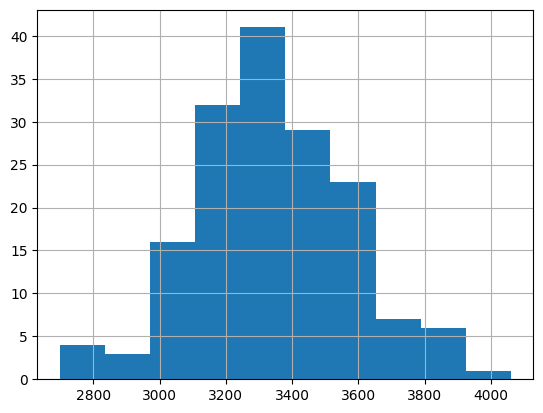

In [67]:
(X_train == 0).sum(axis=1).hist() # per-sample expression

<Axes: >

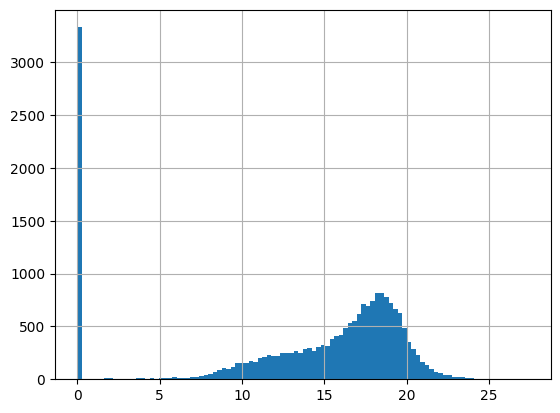

In [16]:
X_train.median().hist(bins=100)

In [78]:
X_train = X_train.loc[:, X_train.median() > 5]

In [18]:
X_train.shape

(162, 17691)

In [19]:
X_train

Gene,A1BGAS,A2BP1,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sampleId,,,,,,,,,,,,,,,,,,,,,
SEQC_NB268,16.5141,16.0565,14.4858,18.9959,0.0000,0.0000,14.6224,9.9727,19.5610,18.4857,...,18.6756,19.2877,15.1439,17.1061,18.7924,13.1769,19.3006,20.4081,18.6951,19.2135
SEQC_NB305,16.5018,19.4637,13.8600,19.6037,0.0000,10.2150,13.6370,9.0725,19.8035,18.2195,...,19.1212,19.7707,14.8420,16.2199,18.2406,9.3781,19.1937,19.1512,19.4345,18.8204
SEQC_NB198,16.5229,15.9915,15.0231,20.5316,0.0000,10.5615,15.0638,0.0000,19.7445,18.2020,...,18.7761,19.4703,14.8728,16.7034,17.7781,0.0000,18.2593,19.9472,18.4226,18.6670
SEQC_NB377,15.4195,18.3650,15.0719,20.2406,11.8042,12.2319,15.1476,11.0234,18.9869,17.9312,...,17.4844,17.3495,15.3507,17.1090,18.2167,10.4633,20.2845,19.8922,18.2359,19.2657
SEQC_NB216,16.4480,19.2702,14.1870,20.1343,12.7286,12.0758,14.5951,11.3425,20.7825,18.7941,...,18.1192,17.7885,14.9989,16.3180,18.6039,0.0000,19.1649,19.7990,19.8302,18.8625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQC_NB218,17.2790,18.4650,14.6535,20.3641,13.4018,0.0000,14.5823,11.6175,20.3679,18.9736,...,18.4607,18.7860,14.6715,16.2595,18.8309,10.5602,19.9761,20.0579,19.3179,18.6212
SEQC_NB244,17.2562,18.8896,15.7909,22.0597,10.9153,11.1139,16.4155,11.7244,19.3001,18.0834,...,17.0470,16.1998,15.2354,16.8942,18.4276,12.9273,19.9850,21.0383,19.1075,18.5479
SEQC_NB328,16.6707,18.9982,13.2940,18.0203,11.4796,0.0000,13.2410,0.0000,20.2103,19.1887,...,18.7715,19.4974,14.9767,16.5994,18.1310,12.3963,19.6283,19.0428,18.5762,19.4349


In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [21]:
X_test_scaled = scaler.transform(X_test.loc[:, X_train.columns])
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_train.columns)

In [22]:
meta_train = meta.loc[X_train.index]
age_scaler = StandardScaler()
age_at_diagnosis = age_scaler.fit_transform(np.array(meta_train.age_at_diagnosis).reshape(-1, 1))
meta_train.age_at_diagnosis = age_at_diagnosis
meta_train.drop("class_label", axis = 1, inplace=True)

In [23]:
X_train_scaled = pd.concat([X_train_scaled, meta_train], axis=1)

In [24]:
meta_test = meta.loc[X_test.index]
age_at_diagnosis = age_scaler.transform(np.array(meta_test.age_at_diagnosis).reshape(-1, 1))
meta_test.age_at_diagnosis = age_at_diagnosis
meta_test.drop("class_label", axis = 1, inplace=True)

In [25]:
X_test_scaled = pd.concat([X_test_scaled, meta_test], axis=1)

# L1 Logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report

In [27]:
model = LogisticRegressionCV(penalty='l1', solver='liblinear', cv = 5, random_state=1234, Cs= 20, class_weight="balanced")
model.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

In [28]:
accuracy

0.9722222222222222

In [29]:
pd.crosstab(y_pred, y_test)

class_label,0,1
row_0,,
0,76,1
1,2,29


In [30]:
pd.crosstab(meta.loc[y_test.index].high_risk, meta.loc[y_test.index].class_label)

class_label,0.0,1.0
high_risk,,
0.0,78,5
1.0,0,25


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98        78
           1       0.94      0.97      0.95        30

    accuracy                           0.97       108
   macro avg       0.96      0.97      0.97       108
weighted avg       0.97      0.97      0.97       108



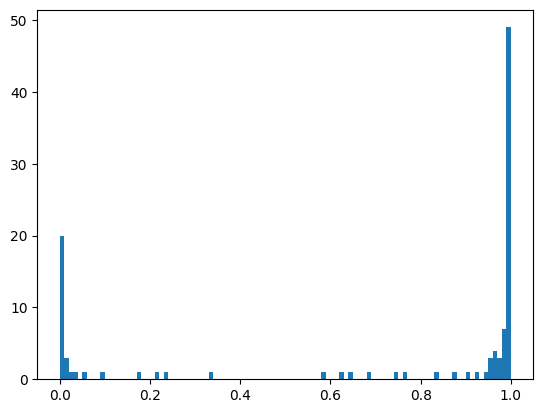

In [32]:
_ = plt.hist(model.predict_proba(X_test_scaled)[:,0], 100)

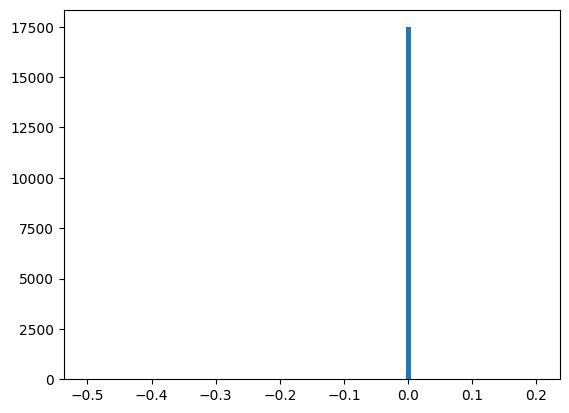

In [33]:
_ = plt.hist(model.coef_[0], 100)

In [34]:
sum(model.coef_[0] != 0)

244

In [35]:
indices = np.argsort(model.coef_[0])[::-1]

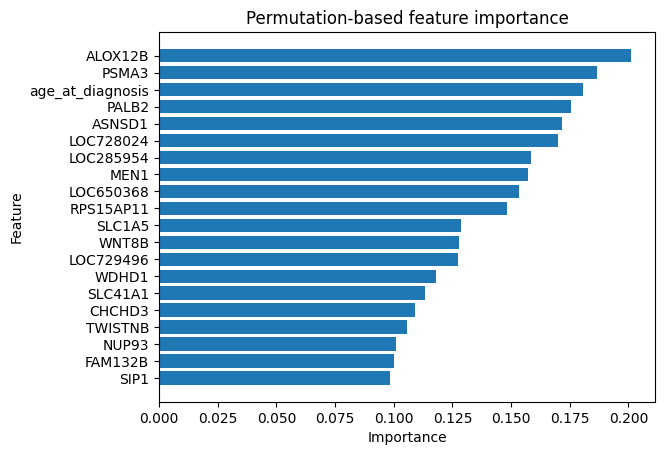

In [36]:
plt.barh(X_train_scaled.columns[indices][range(20)][::-1], model.coef_[0][indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

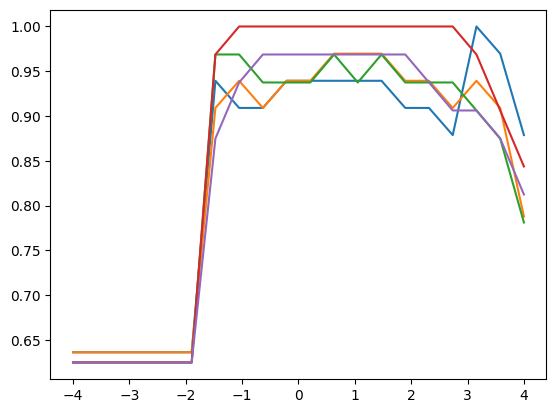

In [37]:
plt.plot(np.log10(model.Cs_), model.scores_[1].T)
plt.show()

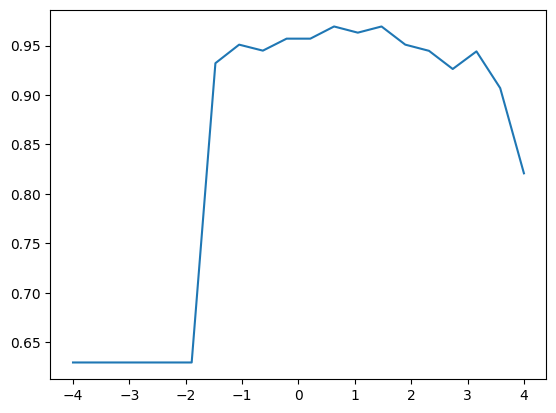

In [38]:
plt.plot(np.log10(model.Cs_), np.mean(model.scores_[1].T, axis = 1))
plt.show()

# Ranodm forest

In [39]:
from sklearn.ensemble import RandomForestClassifier


In [40]:
X_train = pd.concat([X_train, meta_train], axis=1)
X_test = pd.concat([X_test, meta_test], axis=1)

In [41]:
rf_classifier = RandomForestClassifier(n_estimators=1000, random_state=1234, class_weight="balanced")
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test.loc[:, X_train.columns])

In [42]:
accuracy = accuracy_score(y_test, y_pred)

In [43]:
accuracy

0.9907407407407407

In [44]:
pd.crosstab(y_pred, y_test)

class_label,0,1
row_0,,
0,78,1
1,0,29


In [45]:
pd.crosstab(meta.loc[y_test.index].high_risk, meta.loc[y_test.index].class_label)

class_label,0.0,1.0
high_risk,,
0.0,78,5
1.0,0,25


In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        78
           1       1.00      0.97      0.98        30

    accuracy                           0.99       108
   macro avg       0.99      0.98      0.99       108
weighted avg       0.99      0.99      0.99       108



In [47]:
importances = rf_classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

In [48]:
# Print the feature ranking
print("Feature ranking:")
for f in range(20):
    print("%d. %s: feature %d (%f)" % (f + 1, X_train.columns[indices[f]], indices[f], importances[indices[f]]))

Feature ranking:
1. high_risk: feature 17694 (0.011550)
2. PGM2L1: feature 11441 (0.010503)
3. ELK1: feature 3810 (0.008298)
4. MRPL11: feature 9860 (0.007998)
5. CAMTA1: feature 1572 (0.007758)
6. CNIH4: feature 2473 (0.007697)
7. PIRT: feature 11575 (0.006175)
8. POLE3: feature 11809 (0.005702)
9. inss_stage_4: feature 17698 (0.005261)
10. SLC25A5: feature 14312 (0.005155)
11. MAP7: feature 9357 (0.005139)
12. SERINC1: feature 13940 (0.004767)
13. SSR4: feature 14943 (0.004703)
14. SLC25A5P2: feature 14314 (0.004614)
15. FAM70A: feature 4358 (0.004510)
16. HNRNPC: feature 6019 (0.004503)
17. PRMT5: feature 12120 (0.004488)
18. CDK4: feature 2059 (0.004429)
19. KIF5A: feature 6947 (0.004402)
20. USP35: feature 16619 (0.004341)


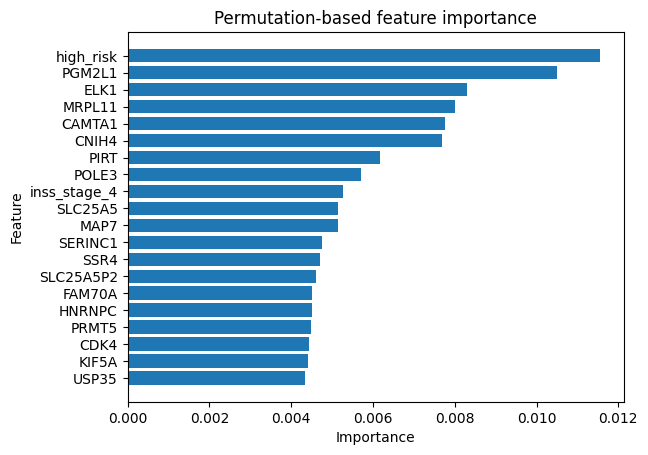

In [49]:
plt.barh(X_train.columns[indices][range(20)][::-1], importances[indices][range(20)][::-1])
plt.title("Permutation-based feature importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

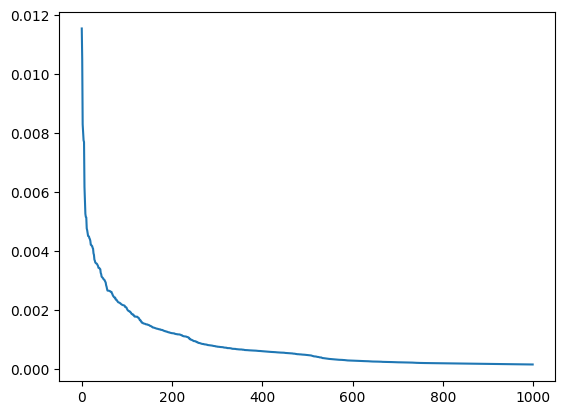

In [56]:
plt.plot(importances[indices][range(1000)])


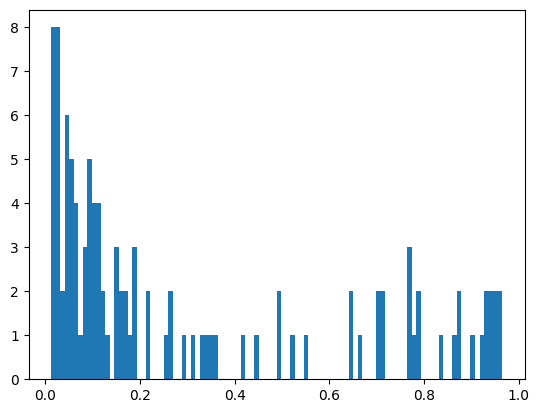

In [53]:
plt.hist(rf_classifier.predict_proba(X_test.loc[:, X_train.columns])[:,1], bins = 100)
plt.show()